In [1]:
import pandas as pd
import re
import contractions
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm  # 반복 작업의 진행 상황을 시각적으로 보여주는 프로그레스 바 라이브러리
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
review_df = pd.read_csv('sample_amazon.csv')
# review_df.head(10) 데이터 확인

# 전처리 함수
def process_text(text):
    
    # 1. HTML 태그 제거거
    text = BeautifulSoup(text, "html.parser").get_text() 
   
    # 2. 축약어 확장
    text = contractions.fix(text)
    
    # 3. 특수 문자 제거
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # 이모지 제거거
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # 특수문자 제거거
    
    # 4. 단어 길이 3 이하 제거
    text = text.lower()
    
    # 5. 공백 정리
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 6. 소문자 변환
    text = text.lower()
    
    # 7. 토큰화 
    tokens = word_tokenize(text)
    
    # 8. 불용어 제거
    stopword_set = set(stopwords.words('english'))  # 변수명 수정!
    tokens = [word for word in tokens if word not in stopword_set]
      
    # 9. 표제어 추출
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

tqdm.pandas()
review_df['cleaned_review'] = review_df['reviewText'].astype(str).progress_apply(process_text)

review_df.head(10) #결과 확인


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\UserK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\UserK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\UserK\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\UserK\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 65%|██████▌   | 116645/179248 [07:16<03:48, 273.97it/s]C:\Users\UserK\AppData\Local\Temp\ipykernel_33036\1845219055.py:21: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package li

,reviewerID,asin,reviewText,overall,cleaned_review
0,AAKKVN6IJJKO1,098949232X,This is one of the best calendars that you can...,5.0,one best calendar buy anyone interested cosmos...
1,A3N778P1L4YH9Y,7391002801,Case is cheaply made. If you aren't using an a...,1.0,case cheaply made using apple charger fit char...
2,A34GGU76V8AE5T,7887421268,I was very excited to find a really cute cover...,2.0,excited find really cute covering evo expectat...
3,A2FZ0P2S6KCJ5P,8288862993,"I purchased this car charger ""Samsung Official...",1.0,purchased car charger samsung official oem car...
4,A2G6OURH28WI8R,9638762632,The PowerBear HTC One M9 Battery Case is absol...,4.0,powerbear htc one m9 battery case absolutely a...
5,A1ZSJCNKDQ6NAO,9638762632,"<a data-hook=""product-link-linked"" class=""a-li...",1.0,powerbear htc one m9 extended rechargeable bat...
6,A137CGRHGFMWYL,9638762632,After a couple of drops the bottom near the he...,3.0,couple drop bottom near headphone jack chipped...
7,AHMRKS7TFV645,9638762632,Very good,5.0,good
8,A23E8JZTC648M0,9707716371,Ordered S5 model and the box says S5 but there...,1.0,ordered s5 model box say s5 s4 battery box pow...
9,A251IRFS97GIP8,9707716436,It worked well when we first got it. Then the ...,2.0,worked well first got top came unhinged would ...


In [2]:
# 평점을 기준으로 레이블 생성
review_df['overrall_label'] = review_df['overall'].apply(lambda x: 1 if x > 3 else 0)
# review_df.head(10) 레이블 확인
# print(review_df['overrall_label'].value_counts()) 샘플링하기 전 확인용

# 긍정/부정 분리
positive_df = review_df[review_df['overrall_label'] == 1]
negative_df = review_df[review_df['overrall_label'] == 0]

# 빈도수 작은 쪽 기준으로 샘플링
min_count = min(len(positive_df), len(negative_df))
pos_df_balanced = positive_df.sample(min_count, random_state=42)
neg_df_balanced = negative_df.sample(min_count, random_state=42)

# 병합 후 무작위 섞기, 인덱스 초기화
balanced_review_df = pd.concat([pos_df_balanced, neg_df_balanced]).sample(frac=1, random_state=42).reset_index(drop=True)

# 결과 확인
print(balanced_review_df['overrall_label'].value_counts())

overrall_label
1    76182
0    76182
Name: count, dtype: int64


In [3]:
from sklearn.model_selection import train_test_split
X = balanced_review_df['cleaned_review']   # 전처리된 텍스트
y = balanced_review_df['overrall_label']   # 긍정(1) or 부정(0) 라벨

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("훈련 데이터 개수:", len(X_train))
print("테스트 데이터 개수:", len(X_test))

#분리된 데이터 DataFrame으로 만들기
train_df = pd.DataFrame({'cleaned_review': X_train, 'label': y_train})
test_df  = pd.DataFrame({'cleaned_review': X_test,  'label': y_test})

훈련 데이터 개수: 121891
테스트 데이터 개수: 30473


In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# One-hot (CountVectorizer)
count_vectorizer = CountVectorizer(binary=True)

X_train_count = count_vectorizer.fit_transform(train_df['cleaned_review'])
X_test_count  = count_vectorizer.transform(test_df['cleaned_review'])

feature_names = count_vectorizer.get_feature_names_out()

# 모델 훈련
clf_count_model = LogisticRegression(max_iter=1000)
clf_count_model.fit(X_train_count, train_df['label'])

# 예측 및 평가
pred_count = clf_count_model.predict(X_test_count)

print("One-hot Encoding 기반 결과")
print("Accuracy :", accuracy_score(test_df['label'], pred_count))
print("Precision:", precision_score(test_df['label'], pred_count))
print("Recall   :", recall_score(test_df['label'], pred_count))
print("F1-score :", f1_score(test_df['label'], pred_count))

# TF-IDF (TfidfVectorizer)
tfidf_vectorizer = TfidfVectorizer()

# 문서 집합에 대해 TF-IDF 계산
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['cleaned_review'])
X_test_tfidf  = tfidf_vectorizer.transform(test_df['cleaned_review'])

# 모델 훈련
clf_tfidf = LogisticRegression(max_iter=1000)
clf_tfidf.fit(X_train_tfidf, train_df['label'])

# 예측 및 평가
pred_tfidf = clf_tfidf.predict(X_test_tfidf)

print("TF-IDF 기반 결과")
print("Accuracy :", accuracy_score(test_df['label'], pred_tfidf))
print("Precision:", precision_score(test_df['label'], pred_tfidf))
print("Recall   :", recall_score(test_df['label'], pred_tfidf))
print("F1-score :", f1_score(test_df['label'], pred_tfidf))

One-hot Encoding 기반 결과
Accuracy : 0.8809109703672103
Precision: 0.8854579044602797
Recall   : 0.8763795467903089
F1-score : 0.8808953362433949
TF-IDF 기반 결과
Accuracy : 0.8864896793883109
Precision: 0.8848701298701299
Recall   : 0.8898974727355842
F1-score : 0.8873766808843161


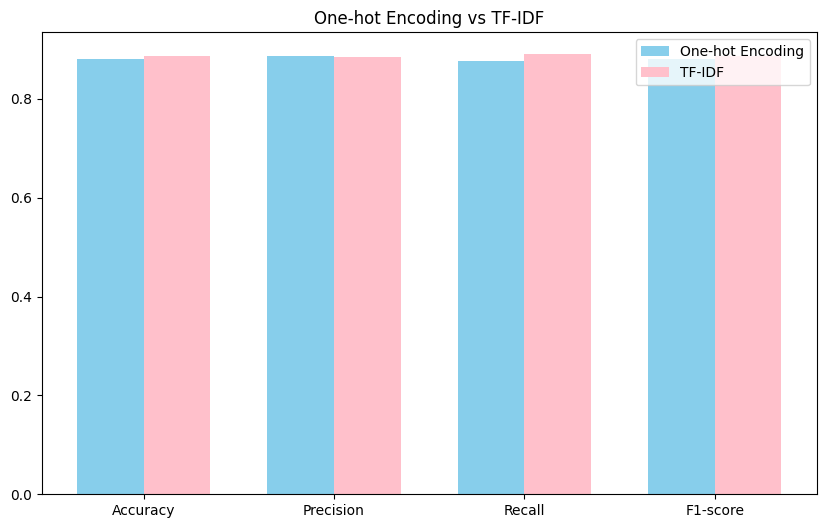

In [5]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

onehot_scores = [
    accuracy_score(test_df['label'], pred_count),
    precision_score(test_df['label'], pred_count),
    recall_score(test_df['label'], pred_count),
    f1_score(test_df['label'], pred_count)
]
tfidf_scores = [
    accuracy_score(test_df['label'], pred_tfidf),
    precision_score(test_df['label'], pred_tfidf),
    recall_score(test_df['label'], pred_tfidf),
    f1_score(test_df['label'], pred_tfidf)
]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, onehot_scores, width, label='One-hot Encoding', color='skyblue')
plt.bar(x + width/2, tfidf_scores, width, label='TF-IDF', color='pink')
plt.title('One-hot Encoding vs TF-IDF')
plt.xticks(x, metrics)

plt.legend()
plt.show()